<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/%EC%BB%AC%EB%9F%BC%EC%9D%B4%EB%A6%84%EB%B6%84%EB%A5%98_re%ED%8C%A8%ED%82%A4%EC%A7%80_%EC%9D%B4%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **디스플레이 생산라인 센서 데이터 분석

## 주제 : 불량품에 영향을 주는 요인 찾기
- 결과 : "ㅇㅇ센서에서 ㅁㅁ면 불량품"
- 주요 요인 피처 5개 추출

## 데이터 불러오기 및 전처리

In [4]:
# 데이터 불러오기
import pandas as pd
fact_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949', index_col=0)
fact_data.info()
fact_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 840 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(834), int64(6)
memory usage: 52.3+ MB


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

## 컬럼이름 분류하기
- 데이터는 센서 데이터로 약 800여개의 컬럼이 있음
- 이름이 비슷한 컬럼이 다수 있으며 생산라인이 Left, Right으로 나뉘어 동일한 공정을 수행중임
- 컬럼이름을 기준으로 컬럼을 분류하고자 함
    - 이름 앞글자가 동일한 컬럼
    - LEFT, RIGHT
- 컬럼을 분류하면 피처 수를 줄여 데이터탐색이 가능함
    - 이름이 유사한 컬럼간 종속성을 확인
    - LEFT, RIGHT 각 공정에 따라 레이블에 미치는 영향 확인 


In [5]:
# 컬럼이름 리스트 저장하기
col = fact_data.columns.tolist()
#col

### 1. 컬럼이름 첫 3글자가 동일한 컬럼 분류
* col_name_3

In [6]:
# 컬럼이름 첫 3글자 같은 컬럼의 집단 개수 확인
col_name_3=[]
for name in col:
    name = str(name)[:3]
    col_name_3.append(name)

print(len(set(col_name_3)))  # 61개

60


In [7]:
# 컬럼이름 첫 3글자가 key, 이름이 유사한 컬럼이 value인 딕셔너리 생성
# 빈 딕셔너리 생성
col_name_3={}
# 인덱스, 컬럼이름에 대해 반복
for i, key in enumerate(col):
    key = str(key)[:3]
    # 만약 key가 딕셔너리에 없으면 키, 인덱스 생성
    if key not in col_name_3:
        col_name_3[key] = [col[i]]
        ## 딕셔너리에 넣을 때 int가 아닌 list로 넣어야 함

    # 만약 key가 딕셔너리에 있으면 인덱스 추가
    else:
        col_name_3[key].append(col[i])

print(len(col_name_3)) # 컬럼집단 61개 잘 만들어짐
#col_name_3

60


### 2. 컬럼이름에 Left, Right가 포함된 컬럼 분류
* dict_l_r
    - Left
    - Right
    - Center : 이름에 확실히 LR이 함께 표기됨
    - Middel : 이름에 L, R 표기 불분명

In [8]:
# re.search에 대한 조사
# re.search에서 여러개의 패턴을 or조건으로 잇기 위해 '' 안에서 |로 이어야 함
#re.search('a|b', 'b') != None

In [9]:
# 컬럼명에 LEFT, RIGHT를 표시하는 글자를 판별하여 분류
# 딕셔너리 개수 균형 확인해보면서 작업

import re

# left, right 분류하여 저장할 딕셔너리 생성
dict_l_r = {'Left':[],
            'Right':[],
            'Center':[]}


for key in col_name_3:
    for i in range(len(col_name_3[key])):

        # 컬럼이름에 문자열 'ㅣ\_r\_', 'lr'가 포함된 경우 딕셔너리에 추가
        # re.search에서 여러개의 패턴을 or조건으로 잇기 위해 '' 안에서 |로 이어야 함
        re_isin_r_l = re.search('l\_r\_|lr', str(col_name_3[key][i].lower())) != None
        if re_isin_r_l:
            dict_l_r['Center'].append(col_name_3[key][i])

        else:
            # 컬럼이름에 문자열 '\_r\_'가 포함된 경우 딕셔너리에 추가
            re_isin_r = re.search('right|\_r\_|\.r\.|\_l\_r', str(col_name_3[key][i].lower())) != None
            if re_isin_r:
                dict_l_r['Right'].append(col_name_3[key][i])

            # 컬럼이름에 문자열 '\_l\_'가 포함된 경우 딕셔너리에 추가
            # l_r이 Left로 들어가는 것을 예방하기 위해 Right를 먼저 판단하고 Left 판단함 
            else:
                re_isin_l = re.search('left|\_l\_|\.l\.|\_l\_l', str(col_name_3[key][i].lower())) != None
                if re_isin_l:
                    dict_l_r['Left'].append(col_name_3[key][i])

                else:
                    # l_, r_으로 시작하는 문자, _l, _r으로 끝나는 문자를 분류
                    re_startend_r = re.search('^r\_|\_r$', str(col_name_3[key][i].lower())) != None
                    #print(re_startend_r)
                    if re_startend_r:
                        dict_l_r['Right'].append(col_name_3[key][i])

                    re_startend_l = re.search('^l\_|\_l$', str(col_name_3[key][i].lower())) != None
                    #print(re_startend_l)
                    #print("#####################"*3)
                    if re_startend_l:
                        dict_l_r['Left'].append(col_name_3[key][i])


# 확인
for key in dict_l_r:
    print(key, ":", len(dict_l_r[key]))
#dict_l_r

Left : 95
Right : 91
Center : 43


In [10]:
import pickle

# 파일 저장
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/dict_left_right.pickle','wb') as fw:
    pickle.dump(dict_l_r, fw)

# load data
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/dict_left_right.pickle', 'rb') as fr:
    dict_l_r_load = pickle.load(fr)

In [11]:
# 딕셔너리를 보기 좋게 출력해서 확인
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(dict_l_r)

{   'Center': [   'l_r_tin_bay1',
                  'l_r_tin_bay10',
                  'l_r_tin_bay5',
                  'l_r_tin_bay7',
                  'l_r_glass',
                  'l_r_top_n.1',
                  'l_r_top_n.2',
                  'D_AB1_U_LR',
                  'D_AB1_L_LR',
                  'D_AB2_U_LR',
                  'D_AB2_L_LR',
                  'D_AB3_U_LR',
                  'D_AB3_L_LR',
                  'D_AB4_U_LR',
                  'D_AB4_L_LR',
                  'D_AB5_U_LR',
                  'D_AB5_L_LR',
                  'D_AB6_U_LR',
                  'D_AB6_L_LR',
                  'D_AB7_U_LR',
                  'D_AB7_L_LR',
                  'D_AB8_U_LR',
                  'D_AB8_L_LR',
                  'D_AB9_U_LR',
                  'D_AB9_L_LR',
                  'D_AB10_U_LR',
                  'D_AB10_L_LR',
                  'D_AB11_U_LR',
                  'D_AB11_L_LR',
                  'D_C1_U_LR',
                  'D_C1_L_L

### dict_l_r 에 포함되지 않은 컬럼 확인


In [ ]:
# dict_l_r에 포함된 컬럼이름(values)를 1차원 리스트로 풀어냄
# https://programmers.co.kr/learn/courses/4008/lessons/12738
value_l_r = list(dict_l_r.values())
value_l_r_flatten = sum(value_l_r, [])

# 확인
len(value_l_r_flatten)  # 174
len(set(value_l_r_flatten))  # 174
# 만약 set의 길이가 더 짧다면 딕셔너리에 중복되어서 들어간 컬럼이 있다는 뜻. 딕셔너리 확인.

229

In [ ]:
# 딕셔너리에서 중복된 value 찾기
# 각 키마다 중복된 value가 있는지 조회함
for val in dict_l_r['Center']:
    if val in dict_l_r['Left']:
        print("Center-Left 중복 :", val)
    if val in dict_l_r['Right']:
        print("Center-Right 중복 :", val)
for val in dict_l_r['Right']:
    if val in dict_l_r['Left']:
        print("Center-Right 중복 :", val)
else:
    print("중복 키 없음")
# Center-Right 중복 : E.L.DB.RIGHT.N2.FLOW.1FI33502.PV
# 해당 컬럼은 .L.과 Right를 모두 포함함
# Right에만 속하는 것이 맞으므로 딕셔너리 Left에서 삭제해야 함
# Center -> Right -> Left 순으로 판단하도록 수정하여 딕셔너리 재생성
# 수정됨

중복 키 없음


In [ ]:
# dict_l_r 에 포함되지 않은 컬럼 확인
# Left, Right에 포함될 컬럼이 있는지 확인해봄
count=0
for i in col:
    if i not in value_l_r_flatten:
        #print(i)  # 컬럼명 확인
        count += 1
print("dict_l_r 에 포함되지 않은 컬럼 수:", count)
# l_, r_으로 시작함 : l_tin, r_tin # l_top, r_top # l_n, r_n
# _L, _R으로 끝남 : _U_L, _U_R 등등
# 딕셔너리 분류규칙에 추가!
# L.RD, L.Vac, R.RD, R.Vac은 레이블이라 분류 안 함. 하고싶으면 딕셔너리 생성 마지막 조건에서 각각 |^r\., |^l\. 추가

dict_l_r 에 포함되지 않은 컬럼 수: 604


In [ ]:
# 컬럼 분류 개수 검증
print("원래 컬럼 개수:", len(col))
print("L, R 분류한 컬럼 개수 + 분류 안 한 컬럼 개수 : ", len(value_l_r_flatten) + count)

원래 컬럼 개수: 833
L, R 분류한 컬럼 개수 + 분류 안 한 컬럼 개수 :  833


### 각 컬럼이 속한 딕셔너리 키를 데이터프레임으로 정리함

In [ ]:
col_name_3.keys()

dict_keys(['LIF', 'LEH', 'DRI', 'X1W', 'DCS', 'DAM', 'DB.', 'N2.', 'ROO', 'ATM', 'SEC', 'clu', 'ML.', 'Rib', 'Gro', 'Lef', 'Rig', 'UPP', 'LOW', 'TMP', 'X.1', 'X.7', 'X.2', 'CAS', 'RET', 'BAT', 'EXI', 'E.L', 'DRO', 'HOO', 'DDP', 'SPO', 'LOR', 'bay', 'l_r', 'l_t', 'r_t', 'lc_', 'le_', 'c_b', 'rc_', 're_', 'top', 'l_n', 'r_n', 'D_A', 'D_C', 'D_G', 'S_A', 'S_C', 'S_R', 'STD', '투입.', 'ROL', '진공패', '폐기율', 'L.R', 'L.V', 'R.R', 'R.V'])

In [ ]:
# 각 컬럼이 속한 딕셔너리 키를 데이터프레임으로 정리함

# Left, Right, Center
df_col = pd.DataFrame(columns = fact_data.columns)
for key, val in dict_l_r.items():
    #print(val)
    for c in val:
        #print(c)
        df_col[c] = [key]
# 분류 안 된 컬럼은 NaN값으로 표시됨
# Middle로 분류하자. - Center는 이름에 확실히 LR이 모두 표시되어 있음
df_col.fillna('Middle', inplace=True)
df_col


# 컬럼이름 3글자 분류
df_ = pd.DataFrame()
for key, val in col_name_3.items():
    for v in val:
        df_[v] = [key]

# 두 컬럼 합치기
df_col_key = pd.concat([df_col, df_], ignore_index=True)
df_col_key

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,...,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Left,Right,Right,Middle,Left,Right,Middle,Middle,Middle,Middle,Middle
1,LIF,LIF,LIF,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,DRI,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,LEH,LEH,DRI,LEH,X1W,X1W,X1W,X1W,X1W,...,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_A,S_A,S_A,S_A,S_A,S_A,S_C,S_C,S_R,S_R,STD,STD,STD,STD,STD,STD,투입.,투입.,ROL,진공패,ROL,진공패,폐기율,ROL,ROL,ROL,L.R,L.V,R.R,R.V


In [ ]:
# df_col_key 파일로 저장
df_col_key.to_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/df_col_key.csv', index=False)

# 불러와서 확인
pd.read_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/df_col_key.csv')

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,...,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Left,Right,Right,Middle,Left,Right,Middle,Middle,Middle,Middle,Middle
1,LIF,LIF,LIF,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,DRI,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,LEH,LEH,DRI,LEH,X1W,X1W,X1W,X1W,X1W,...,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_A,S_A,S_A,S_A,S_A,S_A,S_C,S_C,S_R,S_R,STD,STD,STD,STD,STD,STD,투입.,투입.,ROL,진공패,ROL,진공패,폐기율,ROL,ROL,ROL,L.R,L.V,R.R,R.V


## Left, Right별 상관계수 확인해보기

In [13]:
# Left 생산라인별 컬럼간 상관계수 확인

# 컬럼집단 고르기
dict_l_r.keys()

# 'Left' 컬럼집단의 컬럼명 리스트
col_key = dict_l_r['Left']
col_key

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = fact_data[col_key]
#df

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_

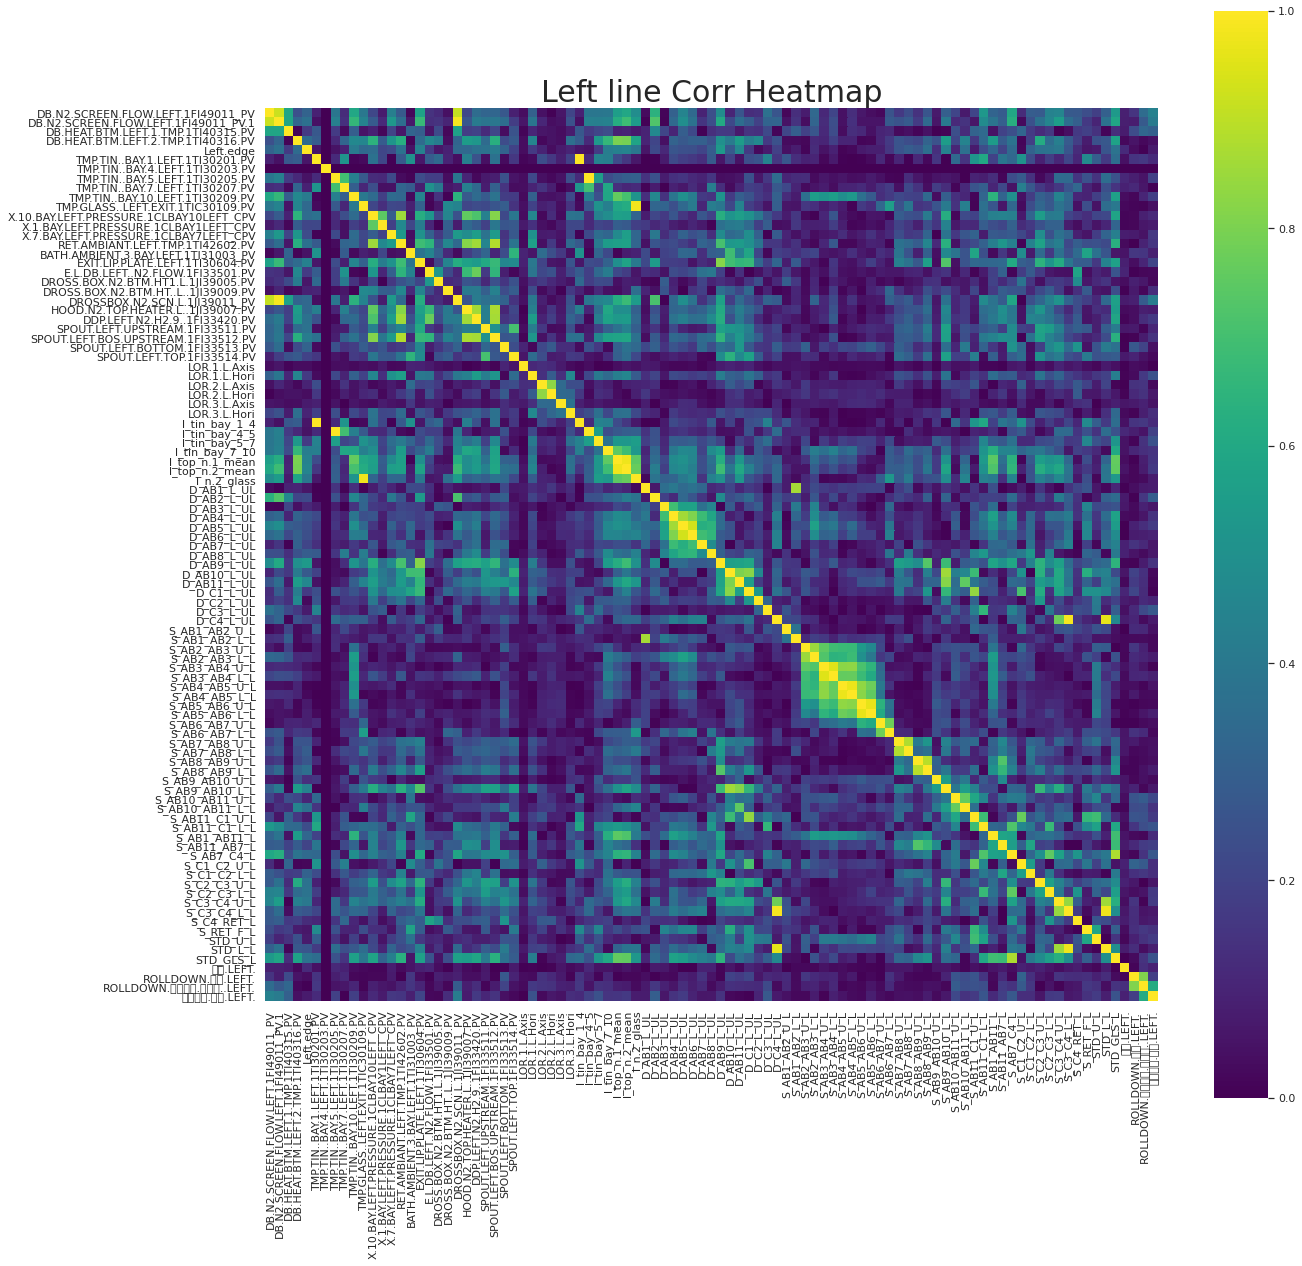

In [15]:
# 상관계수의 절대값 데이터프레임을 배열로 저장
corr_arr = df.corr().to_numpy()
corr_arr = abs(corr_arr)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.set(font_scale=1.0)
sns.heatmap(corr_arr, cmap='viridis', cbar=True, square=True, fmt='.2f', #annot=True, annot_kws={'size':10}, 
            yticklabels=col_key, xticklabels=col_key)
plt.title("Left line Corr Heatmap", fontsize=30)
plt.show()